In [5]:
import sys
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.metrics import roc_auc_score, accuracy_score
sys.path.append("/Users/atticussoane/Desktop/atticus_tools/")
from recursive_selection import FeatureSelector
from dataclasses import dataclass

In [6]:
training = pd.read_csv("./engineered_data/regular_season_ranking_training.csv.gz", compression = "gzip")
validation = pd.read_csv("./engineered_data/regular_season_ranking_validation.csv.gz", compression = "gzip")

training = pd.concat([training, validation], axis = 0).reset_index(drop = True)

train_target = training["team1_win"]
training = training.drop(columns = ["team1_win"])

In [3]:
pd.set_option("max.columns", 100)
training.describe()

,team1_AP_,team1_COL,team1_Conf,team1_DOL,team1_MOR,team1_POM,team1_RTH,team1_SAG,team1_USA_,team1_WLK,team1_WOL,team1_power6_wins,team1_top50_wins,team2_AP_,team2_COL,team2_Conf,team2_DOL,team2_MOR,team2_POM,team2_RTH,team2_SAG,team2_USA_,team2_WLK,team2_WOL,team2_power6_wins,team2_top50_wins
count,87504.000000,87504.00000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.00000,87504.000000,87504.00000
mean,0.108578,168.85075,0.222904,169.010434,168.736561,168.862269,168.828968,168.908187,0.105812,169.014971,169.030593,1.155913,0.578911,0.110372,168.551346,0.223201,168.586910,168.355321,168.472516,168.602532,168.442940,0.107435,168.592933,168.83395,1.163364,0.58427
std,0.311111,99.31322,0.416197,99.394411,99.285391,99.365386,99.381619,99.323193,0.307599,99.385641,99.293272,2.672036,1.402028,0.313355,99.413261,0.416395,99.511306,99.432293,99.451922,99.465202,99.473482,0.309667,99.516273,99.42712,2.678998,1.40759
min,0.000000,1.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000,0.00000
25%,0.000000,82.00000,0.000000,82.000000,82.000000,82.000000,82.000000,82.000000,0.000000,83.000000,82.000000,0.000000,0.000000,0.000000,82.000000,0.000000,82.000000,82.000000,82.000000,82.000000,82.000000,0.000000,82.000000,82.00000,0.000000,0.00000
50%,0.000000,167.00000,0.000000,167.000000,167.000000,167.000000,167.000000,167.000000,0.000000,167.000000,168.000000,0.000000,0.000000,0.000000,167.000000,0.000000,167.000000,166.000000,166.000000,167.000000,167.000000,0.000000,166.000000,167.00000,0.000000,0.00000
75%,0.000000,254.00000,0.000000,254.000000,254.000000,254.000000,254.000000,254.000000,0.000000,255.000000,254.000000,1.000000,0.000000,0.000000,254.000000,0.000000,254.000000,254.000000,254.000000,254.000000,254.000000,0.000000,254.000000,255.00000,1.000000,0.00000
max,1.000000,353.00000,1.000000,353.000000,353.000000,353.000000,353.000000,353.000000,1.000000,353.000000,353.000000,26.000000,17.000000,1.000000,353.000000,1.000000,353.000000,353.000000,353.000000,353.000000,353.000000,1.000000,353.000000,353.00000,25.000000,17.00000


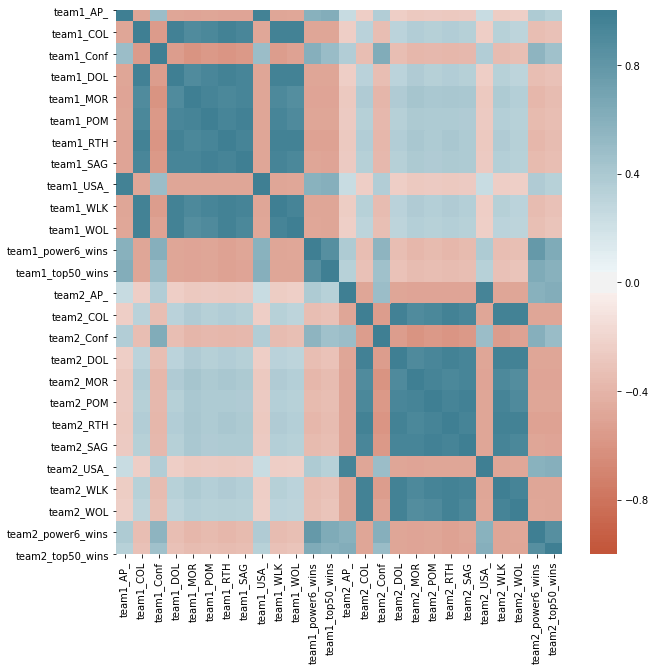

In [4]:
training_corr = training.corr()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(training_corr, cbar = True, vmin = -1, vmax= 1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200), ax = ax);

In [5]:
abs_corr = training_corr.abs()
correlated_pairs = abs_corr.where(np.triu(np.ones(abs_corr.shape), k =1).astype(np.bool)).stack().\
sort_values(ascending = False)

correlated_pairs[correlated_pairs > 0.9]

team2_COL  team2_DOL     0.972656
team1_COL  team1_DOL     0.972496
team2_POM  team2_SAG     0.970330
team1_POM  team1_SAG     0.969973
team2_DOL  team2_WOL     0.968007
team1_DOL  team1_WOL     0.967880
team1_COL  team1_WOL     0.967644
team2_COL  team2_WOL     0.967509
team1_RTH  team1_WOL     0.966235
team2_RTH  team2_WOL     0.966193
team1_COL  team1_RTH     0.964700
team2_COL  team2_RTH     0.964447
team1_DOL  team1_WLK     0.960337
team2_COL  team2_WLK     0.960297
team2_DOL  team2_RTH     0.960198
team1_COL  team1_WLK     0.960173
team1_RTH  team1_WLK     0.960102
team2_DOL  team2_WLK     0.960100
team1_DOL  team1_RTH     0.960017
team2_RTH  team2_WLK     0.959953
team1_AP_  team1_USA_    0.958427
team2_SAG  team2_WLK     0.952800
team2_RTH  team2_SAG     0.952197
team2_AP_  team2_USA_    0.952122
team2_MOR  team2_POM     0.951999
team1_SAG  team1_WLK     0.951914
team1_RTH  team1_SAG     0.951530
team1_MOR  team1_POM     0.951363
team2_WLK  team2_WOL     0.951346
team1_WLK  tea

In [3]:
def feature_frame_correlation(feature_frame, tol = None):
    feature_corr = feature_frame.corr().abs()
    correlated_pairs = feature_corr.where(np.triu(np.ones(feature_corr.shape), k =1).\
                                          astype(np.bool)).stack().sort_values(ascending = False)
    if tol:
        return(correlated_pairs[correlated_pairs > tol])
    else:
        return(correlated_pairs)
    
def get_correlation_with_winning(subset, df, target):
    df = pd.concat([df, target], axis = 1)
    partial = df[subset]
    partial_corr = partial.corr().abs()
    correlated_pairs = partial_corr.where(np.triu(np.ones(partial_corr.shape), k =1)\
                                      .astype(np.bool)).stack().sort_values(ascending = False)
    with_target = []
    for i in correlated_pairs.index:
        if "team1_win" in i:
            with_target.append(i)
    return(correlated_pairs[with_target])

def scale_features(data, binary_features, load_scaler = None, save_scaler = False):
    if binary_features:
        to_scale = data.drop(columns = binary_features)
    else:
        to_scale = data
    scale_columns = list(to_scale.columns)
    npX = np.array(to_scale)
    
    if not load_scaler:
        ss = StandardScaler()
        ss.fit(npX)
    else:
        ss = load_scaler
    npX = ss.transform(npX)
    scaled_X = pd.DataFrame(npX)
    scaled_X.columns = scale_columns
    if binary_features:
        scaled_X = pd.concat([scaled_X, data[binary_features]], axis = 1)
    if save_scaler:
        return(scaled_X, ss)
    else:
        return(scaled_X)

def recursive_VIF(training_data, tol, binary_features):
    over_tolerance = []
    if binary_features:
        training_data = training_data.drop(columns = binary_features)
    while True:
        training_data = training_data.assign(constant = 1)
        all_cols = list(training_data.columns)
        npX = np.array(training_data)
        vif = [variance_inflation_factor(npX, i) for i in np.arange(npX.shape[1])]
        vif_ = pd.Series(vif, index = all_cols)
        vif_ = vif_.drop('constant')
        max_vif = vif_.idxmax()
        if vif_.max() > tol:
            training_data = training_data.drop(columns = [max_vif, 'constant'])
            over_tolerance.append((max_vif, vif_[max_vif]))
        else:
            return(over_tolerance)
        
def display_coef(training_data, model):
    features = list(training_data.columns)
    try:
        coefs = list(abs(model.coef_[0]))
    except:
        coefs = list(abs(model.coef_))
    coef_frame = pd.DataFrame({"feature" : features, "coefficient" : coefs}).\
    sort_values(by = ["coefficient"], ascending = False)
    zero_val = coef_frame[coef_frame.coefficient == 0.].feature
    print("There are {} coefficients with zero coefficient".format(len(zero_val)))
    print()
    print(zero_val.values)
    return(coef_frame)

In [7]:
training.head()

,team1_AP_,team1_COL,team1_Conf,team1_DOL,team1_MOR,team1_POM,team1_RTH,team1_SAG,team1_USA_,team1_WLK,team1_WOL,team1_power6_wins,team1_top50_wins,team2_AP_,team2_COL,team2_Conf,team2_DOL,team2_MOR,team2_POM,team2_RTH,team2_SAG,team2_USA_,team2_WLK,team2_WOL,team2_power6_wins,team2_top50_wins
0,0,27,1,27,13,15,9,11,0,14,5,0,0,0,9,1,11,4,20,25,27,0,23,21,0,0
1,0,52,0,72,40,41,15,61,0,80,11,0,0,0,37,1,16,57,40,20,60,0,110,35,0,0
2,0,155,0,144,188,173,199,190,0,171,215,0,0,0,169,0,194,235,267,265,248,0,244,249,0,0
3,0,47,1,52,36,46,71,54,0,24,85,0,0,0,18,0,10,52,25,34,32,0,33,38,0,0
4,0,12,1,13,29,49,21,46,0,65,20,0,0,0,11,1,9,18,9,19,18,0,20,19,0,0


In [8]:
top25_rankings = ["team1_AP_", "team1_USA_", "team2_AP_", "team2_USA_", "team1_win"]
full_ratings = ["team1_COL", "team1_COL", "team1_DOL", "team1_MOR", "team1_POM", "team1_RTH", "team1_SAG", 
               "team1_WLK", "team1_WOL", "team1_win"]
other = ["team1_Conf", "team1_power6_wins", "team1_top50_wins", "team2_Conf", 
        "team2_power6_wins", "team2_top50_wins", "team1_win"]

In [9]:
get_correlation_with_winning(top25_rankings, training, train_target)

team2_USA_  team1_win    0.143374
team2_AP_   team1_win    0.142817
team1_AP_   team1_win    0.142709
team1_USA_  team1_win    0.141514
dtype: float64

In [10]:
get_correlation_with_winning(full_ratings, training, train_target)

team1_WOL  team1_win    0.308805
team1_COL  team1_win    0.303126
           team1_win    0.303126
           team1_win    0.303126
           team1_win    0.303126
team1_DOL  team1_win    0.302491
team1_WLK  team1_win    0.300028
team1_RTH  team1_win    0.289723
team1_POM  team1_win    0.282036
team1_SAG  team1_win    0.275831
team1_MOR  team1_win    0.261545
dtype: float64

In [11]:
get_correlation_with_winning(other, training, train_target)

team2_Conf         team1_win    0.107888
team1_Conf         team1_win    0.106841
team2_top50_wins   team1_win    0.093920
team1_top50_wins   team1_win    0.089768
team2_power6_wins  team1_win    0.076303
team1_power6_wins  team1_win    0.070676
dtype: float64

In [12]:
team2_full = [i.replace("team1", "team2", 1) for i in full_ratings]
team2_full.pop()
team2_full.append("team1_win")
get_correlation_with_winning(team2_full, training, train_target)

team2_WOL  team1_win    0.310611
team2_COL  team1_win    0.306764
           team1_win    0.306764
           team1_win    0.306764
           team1_win    0.306764
team2_DOL  team1_win    0.306755
team2_WLK  team1_win    0.301526
team2_RTH  team1_win    0.291287
team2_POM  team1_win    0.281149
team2_SAG  team1_win    0.277571
team2_MOR  team1_win    0.264324
dtype: float64

In [14]:
binary_features_full = ["team1_AP_", "team2_AP_", "team1_USA_", "team2_USA_", "team1_Conf", "team2_Conf"]
VIF_drop = recursive_VIF(training, 5.0, binary_features_full)
VIF_drop

[('team2_RTH', 34.37579392222452),
 ('team1_RTH', 32.85106270508832),
 ('team2_DOL', 28.663018605458774),
 ('team1_DOL', 28.496530413182825),
 ('team2_SAG', 23.794872230299706),
 ('team1_SAG', 23.47058845245539),
 ('team1_COL', 21.825119902808467),
 ('team2_COL', 21.683834416560924),
 ('team2_WLK', 18.213749581233305),
 ('team1_WLK', 17.624599284342178),
 ('team2_POM', 14.261108775835467),
 ('team1_POM', 13.906976344274174),
 ('team2_power6_wins', 6.518958068715635)]

In [17]:
VIF_drop_cols = [i[0] for i in VIF_drop]

Clearly collinearity and multicollinearity is a huge factor in this dataset. In cases like this, LassoCV can be a useful tool for feature selection. I am going to experiment with different feature sets to see if what the best set to pursue is.

# FEATURE SELECTION

In [8]:
#scale features before LassoCV
scaled_training, ss = scale_features(training, binary_features_full, save_scaler = True)

In [9]:
with open("./models/regular_season_rankings_standard_scaler.pk", "wb") as f:
    pickle.dump(ss, f)

## LassoCV selection

In [16]:
lassoCV_params = {
    "eps" : 0.001,
    "n_alphas" : 100,
    "alphas" : None,
    "fit_intercept" : False,
    "cv" : 10,
    "n_jobs" : -1,
    "selection" : "random"
}

lasso = LassoCV().set_params(**lassoCV_params)
lasso.fit(scaled_training, train_target)

coefs = display_coef(scaled_training, lasso)
coefs

There are 0 coefficients with zero coefficient

[]


,feature,coefficient
24,team1_Conf,0.452074
25,team2_Conf,0.401809
20,team1_AP_,0.284113
14,team2_RTH,0.267228
21,team2_AP_,0.237881
7,team1_WOL,0.161297
8,team1_power6_wins,0.121981
12,team2_MOR,0.120665
18,team2_power6_wins,0.119130
22,team1_USA_,0.112690


In [30]:
selector = FeatureSelector(scaled_training, train_target, params = {"n_estimators" : 100})
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [20]:
tree_reduced = scaled_training[selector.best_subset]

lasso_reduced = scaled_training[list(coefs["feature"][:10].values)]

col_reduced = scaled_training[["team1_AP_", "team2_AP_", "team1_WOL", "team2_WOL", "team1_Conf", 
                                "team2_Conf","team1_top50_wins", "team2_top50_wins"]]
VIF_reduced = scaled_training.drop(columns = VIF_drop_cols)

In [73]:
@dataclass
class CVWrapper():
    data: any
    target: pd.core.frame.Series
    algorithm: object
    params: dict
    scoring: str = "roc_auc"
    cv: int = 5
    n_jobs: int = -1
    best_eval: float = 0.
    best_subset: list = None
        
    def evaluate(self):
        if type(self.data) == dict:
            for key in self.data:
                cv_score = self.cv_(self.data[key], self.target, self.algorithm, self.params, self.scoring,
                                  self.cv, self.n_jobs)
                if cv_score > self.best_eval:
                    self.best_eval = cv_score
                    self.best_subset = list(self.data[key].columns)
                print("CV Score of {} was: {}".format(key, cv_score))
        else:
            cv_score = self.cv_(self.data, self.target, self.algorithm, self.params, self.scoring,
                              self.cv, self.n_jobs)
            self.best_eval = cv_score
            self.best_subset = list(self.data.columns)
            print("CV Score was {}".format(self.best_eval))
        
    @staticmethod
    def cv_(xtrain, ytrain, algorithm, params, scoring, cv, n_jobs):
        if params:
            algorithm.set_params(**params)
        cv_score = cross_val_score(algorithm, xtrain, ytrain, scoring = scoring,
                                   cv = cv, n_jobs = n_jobs).mean()
        return(cv_score)

In [62]:
dfs = {
    "full" : scaled_training,
    "lasso_reduced" : lasso_reduced,
    "collinearity_reduced" : col_reduced,
    "VIF_reduced" : VIF_reduced,
    "tree_reduced" : tree_reduced
}
params = {
    "C" : 0.1,
    "fit_intercept" : False,
    "penalty" : "l1", 
    "solver" : "liblinear"
}

cv = CVWrapper(dfs, train_target, LogisticRegression(), params)
cv.evaluate()

CV Score of full was: 0.8210875698140466
CV Score of lasso_reduced was: 0.8135347327433516
CV Score of collinearity_reduced was: 0.812080811820454
CV Score of VIF_reduced was: 0.8164752612379335
CV Score of tree_reduced was: 0.8210906424556532


In [63]:
l2_params = {
    "C" : 0.1,
    "fit_intercept" : False,
    "penalty" : "l2",
    "solver" : "lbfgs"
}

cv = CVWrapper(dfs, train_target, LogisticRegression(), l2_params)
cv.evaluate()

CV Score of full was: 0.8209238900851137
CV Score of lasso_reduced was: 0.8135121529779796
CV Score of collinearity_reduced was: 0.8120698924835054
CV Score of VIF_reduced was: 0.8164431911171495
CV Score of tree_reduced was: 0.8209341143834369


After comparing 4 different feature reduction techniques: collinearity, multicollinearity (VIF), LassoCV, and tree-based (feature importance) the highest performing feature set is the full set using an L1 penalty. Now, of course, the L1 regularization penalty performs feature selection of its own as it is capable of reducing coefficients to 0, but the reduced feature sets with L2 regularization performed lower as well. 

# Model Tuning

In [59]:
@dataclass
class GridSearchWrapper():
    xtrain: pd.core.frame.DataFrame
    ytrain: pd.core.frame.Series
    algorithm: object
    init_params: dict
    search_params : dict
    scoring = "roc_auc"
    cv = 5
    n_jobs = -1
    best_score: float = None
    best_params: dict = None
    
    def search(self):
        self.algorithm.set_params(**self.init_params)
        grid_search = GridSearchCV(self.algorithm, param_grid = self.search_params, scoring = self.scoring,
                                  n_jobs = self.n_jobs, cv = self.cv)
        grid_search.fit(self.xtrain, self.ytrain)
        self.best_score = grid_search.best_score_
        self.best_params = grid_search.best_params_
        print("Best score: {}".format(self.best_score))
        print()
        print("Best parameters: {}".format(self.best_params))
        

## Hinge loss

In [60]:
#set non-default hyperparameters before grid search
SVM_init = {
    "fit_intercept" : False,
    "eta0" : 0.1,
}

SVM_param_search = {
    "loss" : ["hinge", "squared_hinge"],
    "penalty" : ["l1", "l2", "elasticnet"],
    "alpha" : [0.0001, 0.001, 0.1],
    "learning_rate" : ["optimal", "adaptive"]    
}

tune_SVM = GridSearchWrapper(scaled_training, train_target, SGDClassifier(), SVM_init, SVM_param_search)
tune_SVM.search()

Best score: 0.8215712987964614

Best parameters: {'alpha': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'penalty': 'l1'}


## Modified Huber Loss

In [65]:
huber_init = {
    "fit_intercept" : False,
    "eta0" : 0.1,
    "loss" : "modified_huber"
}

huber_param_search = {
    "penalty" : ["l1", "l2", "elasticnet"],
    "alpha" : [0.0001, 0.001, 0.1],
    "learning_rate" : ["optimal", "adaptive"]    
}

tune_Huber = GridSearchWrapper(scaled_training, train_target, SGDClassifier(), huber_init, huber_param_search)
tune_Huber.search()

Best score: 0.8210866800671004

Best parameters: {'alpha': 0.001, 'learning_rate': 'adaptive', 'penalty': 'l1'}


## Perceptron Loss

In [66]:
perceptron_init = {
    "fit_intercept" : False,
    "eta0" : 0.1,
    "loss" : "perceptron"
}

perceptron_param_search = {
    "penalty" : ["l1", "l2", "elasticnet"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "learning_rate" : ["optimal", "adaptive", "constant"]
}

tune_Perceptron = GridSearchWrapper(scaled_training, train_target, SGDClassifier(), perceptron_init,
                                   perceptron_param_search)
tune_Perceptron.search()

Best score: 0.7675981605472619

Best parameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}


# With adaptive learning rate scheduler, need to tune initial learning rate

In [67]:
SVM_init = {
    "fit_intercept" : False,
    "loss" : "squared_hinge",
    "alpha" : 0.001,
    "learning_rate" : "adaptive", 
    "penalty" : "l1",
    "eta0" : 0.1 #even though we are tuning this parameter, need to pass a value for SGD __init__
}

learning_rate = {
    "eta0" : [0.001, 0.01, 0.1, 1.0, 10.]
}

tune_learningRate = GridSearchWrapper(scaled_training, train_target, SGDClassifier(), SVM_init,
                                     learning_rate)
tune_learningRate.search()

Best score: 0.8214174603843231

Best parameters: {'eta0': 0.1}


In [70]:
final_params = {
    "fit_intercept" : False,
    "loss" : "squared_hinge",
    "alpha" : 0.001,
    "learning_rate" : "adaptive",
    "penalty" : "l1",
    "eta0" : 0.1
}

sgd_final = SGDClassifier().set_params(**final_params)
sgd_final.fit(scaled_training, train_target)

with open("./models/reg_season_rankings_SVM.pk", "wb") as f:
    pickle.dump(sgd_final, f)

display_coef(scaled_training, sgd_final)

There are 9 coefficients with zero coefficient

['team2_COL' 'team2_WOL' 'team2_power6_wins' 'team1_top50_wins'
 'team2_AP_' 'team1_USA_' 'team1_power6_wins' 'team1_WOL' 'team1_COL']


,feature,coefficient
14,team2_RTH,0.366906
4,team1_RTH,0.360734
5,team1_SAG,0.230994
15,team2_SAG,0.219866
20,team1_AP_,0.149242
23,team2_USA_,0.145229
16,team2_WLK,0.125920
6,team1_WLK,0.120770
25,team2_Conf,0.116854
24,team1_Conf,0.116616


In [78]:
ranking_cols = list(scaled_training.columns)

with open("./models/regular_season_ranking_features.json", "w+") as f:
    json.dump(ranking_cols, f)